In [1]:
import os, sys
import argparse
import pandas as pd
import numpy as np
import pickle

In [2]:
from dateutil.parser import parse
from datetime import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.options.mode.chained_assignment = None #to run loop quicker without warnings

In [3]:
#name = 'bpi_2012'
name = 'bpi_2013'
#name = 'helpdesk'
args = {
    'data_dir': '../data/',
    'data_file': name + '.csv',
    'input_dir': '../input/{}/'.format(name),  
    'train_pct': 0.6,
    'val_pct': 0.2,
    'anomaly_pct': 0.1,
    'scaler': 'standardization',
}

args = argparse.Namespace(**args)

In [4]:
if not os.path.isdir('../input/'):
    os.makedirs('../input/')
    
if not os.path.isdir(args.input_dir):
    os.makedirs(args.input_dir)

In [5]:
sys.path.insert(0, './../utils/')
from utils import *

In [6]:
preprocessed_data_name = os.path.join(args.input_dir, 'preprocessed_data_{}.pkl'.format(args.anomaly_pct))
with open(preprocessed_data_name, 'rb') as f:
    input_train = pickle.load(f)
    input_val = pickle.load(f)
    input_test = pickle.load(f)
    pad_index_train = pickle.load(f)
    pad_index_val = pickle.load(f)
    pad_index_test = pickle.load(f)
    activity_label_train = pickle.load(f)
    activity_label_val = pickle.load(f)
    activity_label_test = pickle.load(f)
    time_label_train = pickle.load(f)
    time_label_val = pickle.load(f)
    time_label_test = pickle.load(f)
    train_case_num = pickle.load(f)
    val_case_num = pickle.load(f)
    test_case_num = pickle.load(f)
    train_row_num = pickle.load(f)
    val_row_num = pickle.load(f)
    test_row_num = pickle.load(f)
    min_value = pickle.load(f)
    max_value = pickle.load(f)
    mean_value = pickle.load(f)
    std_value = pickle.load(f)
    cols = pickle.load(f)
    statistics_storage = pickle.load(f)

# Load data

In [8]:
normal_df_name = os.path.join(args.input_dir, 'normal_df_{}.csv'.format(args.anomaly_pct))
normal_df = pd.read_csv(normal_df_name)

anomalous_df_name = os.path.join(args.input_dir, 'anomolous_df_{}.csv'.format(args.anomaly_pct))
anomalous_df = pd.read_csv(anomalous_df_name)

In [9]:
normal_df.head()

,CaseID,Activity,CompleteTimestamp,Duration,CumDuration
0,1,Queued-Awaiting Assignment,2006-01-11 23:49:42,0.0,0.0
1,1,Accepted-In Progress,2012-03-15 19:53:52,194817850.0,194817850.0
2,1,Accepted-Assigned,2012-03-15 19:56:17,145.0,194817995.0
3,1,Accepted-In Progress,2012-03-15 20:09:05,768.0,194818763.0
4,1,Completed-Closed,2012-03-15 20:11:33,148.0,194818911.0


In [10]:
anomalous_df.head()

,CaseID,AnomalousActivity,AnomalousCompleteTimestamp,AnomalousDuration,AnomalousCumDuration,ActivityLabel,TimeLabel
0,1,Queued-Awaiting Assignment,2006-01-11 23:49:42.000000,0.000000e+00,0.000000e+00,0,0
1,1,Unmatched-Unmatched,2012-03-15 19:53:52.000000,1.948178e+08,1.948178e+08,1,0
2,1,Accepted-Assigned,2012-09-29 07:22:32.331045,1.706212e+07,2.118800e+08,0,1
3,1,Accepted-In Progress,2012-03-15 20:09:05.000000,7.680000e+02,1.948188e+08,0,0
4,1,Completed-Closed,2012-03-15 20:11:33.000000,1.480000e+02,1.948189e+08,0,0


# Plot

In [11]:
def histogram_plot(df, activity):
    selected_df = df[df['Activity']==activity]['Duration']
    selected_df.hist()
    plt.axvline(selected_df.mean(), color='w', linestyle='dashed', linewidth=2)
    plt.axvline(selected_df.mean()+selected_df.std(), color='r', linestyle='dashed', linewidth=2)
    plt.title('Histogram of '+ act)
    plt.savefig(args.input_dir + 'histogram_'+act)
    plt.show()
    plt.close()

In [12]:
act_list = normal_df['Activity'].unique()
print('Activity: {}'.format(act_list))

Activity: ['Queued-Awaiting Assignment' 'Accepted-In Progress' 'Accepted-Assigned'
 'Completed-Closed' 'Accepted-Wait' 'Unmatched-Unmatched'
 'Completed-Cancelled']


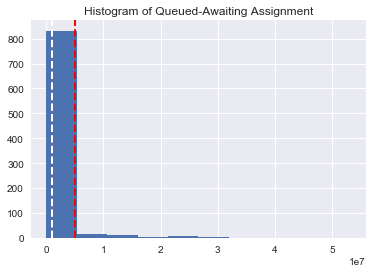

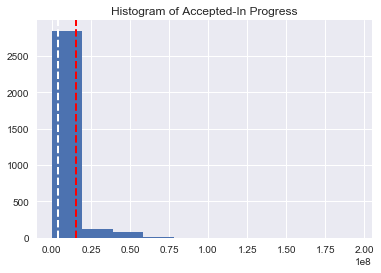

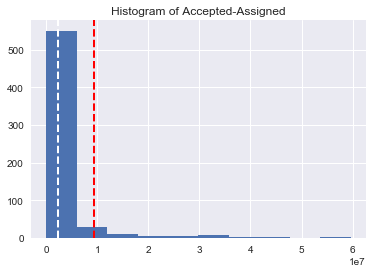

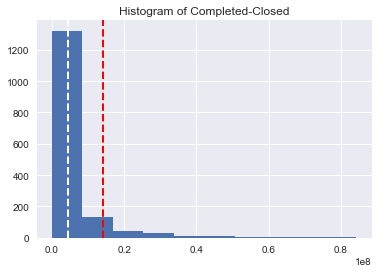

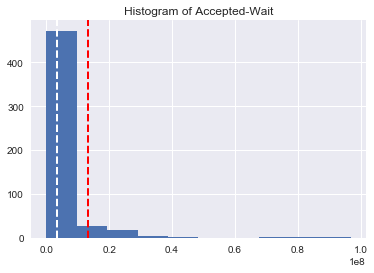

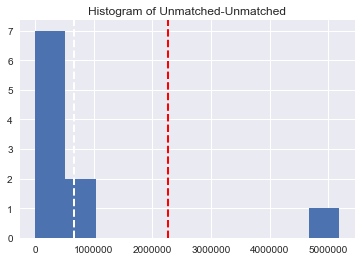

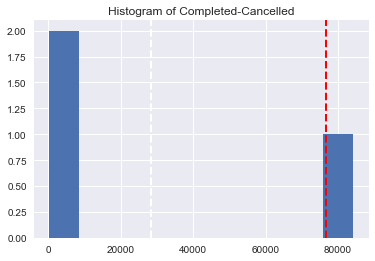

In [14]:
for act in act_list:
    histogram_plot(normal_df, act)